In [1]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from abc import ABCMeta, abstractmethod

%matplotlib inline
plt.rcParams['axes.unicode_minus']=False
engine = create_engine('sqlite:///fund.db')

In [2]:
class ProfitVisualize(metaclass=ABCMeta):
    
    '''
    input:該月所有淨值（已對齊）
    output:整理出的features
    '''
    @abstractmethod
    def getFeatures(self, month_NAV,month_len):
        pass
    
    '''
    input:整理出的features
    output:聚類過的資料
    '''
    @abstractmethod
    def doClustering(self, features):
        pass
    
    def getProfitPicture(self):
        year = input("請輸入欲回測年：")
        month_data = pd.read_sql(sql='select * from price where date between ? and ? order by date asc',
                                 con=engine,index_col='date', params=[year+'-12-01',year+'-12-31'])
        random_names = month_data['id'].sample(n=300).values
        month_date = pd.read_sql(sql='select distinct date from price where date between ? and ? order by date asc',
                                 con=engine,index_col='date', params=[year+'-12-01',year+'-12-31']).index
        month_date_len = len(month_date)
        month_NAV = np.zeros((300,month_date_len))
        for j in range (300):
            temp = month_data[month_data['id'] == random_names[j]]
            month_NAV[j][0] = temp.iloc[0]['NAV']
            for i,day in enumerate(month_date[1:]):
                try:
                    month_NAV[j][i+1] = temp.loc[day]['NAV']
                except:
                    month_NAV[j][i+1] = month_NAV[j][i]
        
        features = self.getFeatures(month_NAV,month_date_len)
        clustering = self.doClustering(features)
        mds = MDS(n_components=2, dissimilarity='euclidean', n_jobs=8).fit(features).embedding_
        
        plt.figure(figsize=(15, 15))
        plt.subplots_adjust(bottom=0.1)
        plt.scatter(mds[:, 0], mds[:, 1], c=clustering.labels_)
        plt.show()
        
        data = pd.read_sql(sql='select * from price where date between ? and ? order by date asc',
                           con=engine,index_col='date', params=[year+'-01-01',year+'-12-31'])
        camp = pd.DataFrame(data=clustering.labels_, index=random_names,columns=['label'])
        choose_name = []
        for i in range(4):
            choose_name.append(camp[camp['label'] == i].sample(n=1).index[0])
        choose_name.append('0050 元大台灣50')
        year_date = pd.read_sql(sql='select distinct date from price where date between ? and ? order by date asc',
                                con=engine,index_col='date', params=[year+'-01-01',year+'-12-31']).index
        year_date_len = len(year_date)
        year_NAV = np.zeros((5,year_date_len))
        for j in range (5):
            temp = data[data['id'] == choose_name[j]]
            year_NAV[j][0] = temp.iloc[0]['NAV']
            for i,day in enumerate(year_date[1:]):
                try:
                    year_NAV[j][i+1] = temp.loc[day]['NAV']
                except:
                    year_NAV[j][i+1] = year_NAV[j][i]
        choose_profit = []
        compare__profit = []
        start = (year_NAV[0][0] + year_NAV[1][0] + year_NAV[2][0] + year_NAV[3][0])/4
        for i in range(year_date_len):
            temp = (year_NAV[0][i] + year_NAV[1][i] + year_NAV[2][i] + year_NAV[3][i])/4
            temp = (temp-start)/start*100
            choose_profit.append(temp)
            compare__profit.append((year_NAV[4][i]-year_NAV[4][0])/year_NAV[4][0]*100)
            
        plt.figure(figsize=(14, 14))
        plt.xlabel('月日')
        plt.ylabel('收益率')
        plt.title('收益率對比')
        plt.plot(year_date, choose_profit, label='四檔基金')
        plt.plot(year_date, compare__profit, color = 'r', label='台灣50')
        plt.show()

In [3]:
class ClusterStrategy(metaclass=ABCMeta):
    @abstractmethod
    def Clustering(self,features):
        pass

In [4]:
class ClusterMethod:
    def __init__(self, clusterStrategy):
        self.clusterStrategy = clusterStrategy
    
    def startClustering(self,features):
        return self.clusterStrategy.Clustering(features)

In [5]:
class K_Means(ClusterStrategy):
    def Clustering(self,features):
        return KMeans(n_clusters=4).fit(features)

In [6]:
class Hierarchical(ClusterStrategy):
    def Clustering(self,features):
        return AgglomerativeClustering(n_clusters=4).fit(features)

# 實作框架

In [7]:
class KUpDownRate(ProfitVisualize):
    
    def getFeatures(self, month_NAV,date_len):
        date_len = date_len-1
        month_rate = np.zeros((300,date_len))
        for j in range (300):
            for i in range (date_len):
                month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]
        return month_rate
    
    def doClustering(self, features):
        return ClusterMethod(K_Means()).startClustering(features)

In [8]:
class HUpDownRate(ProfitVisualize):
    def getFeatures(self, month_NAV,date_len):
        date_len = date_len-1
        month_rate = np.zeros((300,date_len))
        for j in range (300):
            for i in range (date_len):
                month_rate[j][i] = (month_NAV[j][i+1] - month_NAV[j][i]) / month_NAV[j][i]
        return month_rate
    
    def doClustering(self, features):
        return ClusterMethod(Hierarchical()).startClustering(features)

請輸入欲回測年：2015


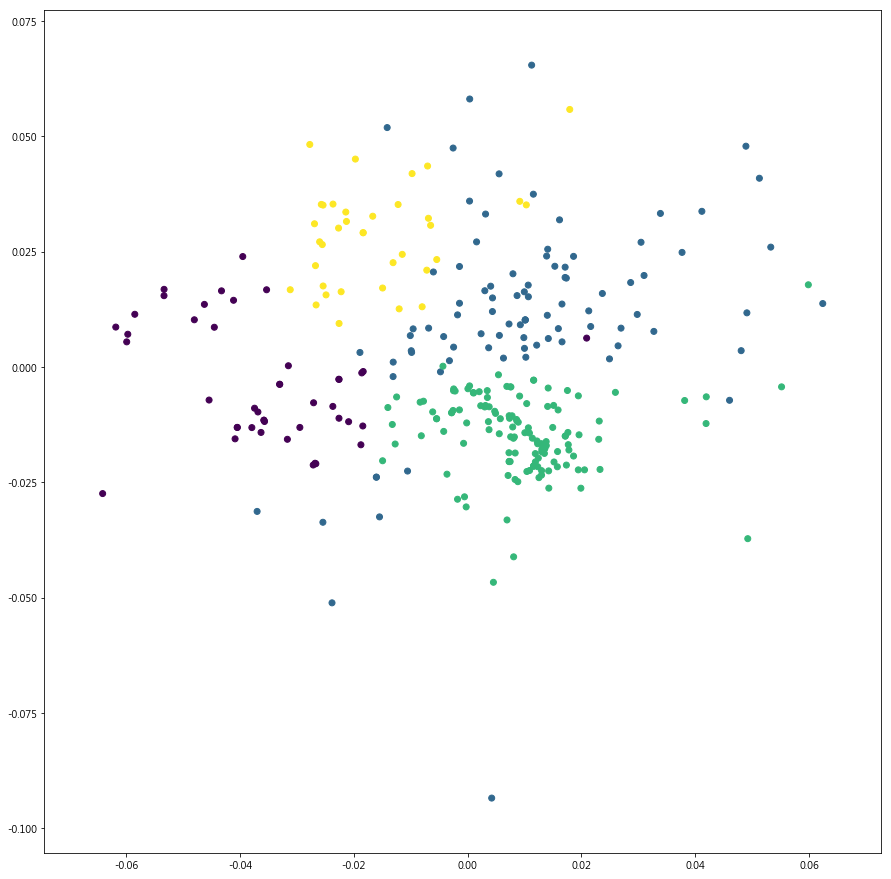

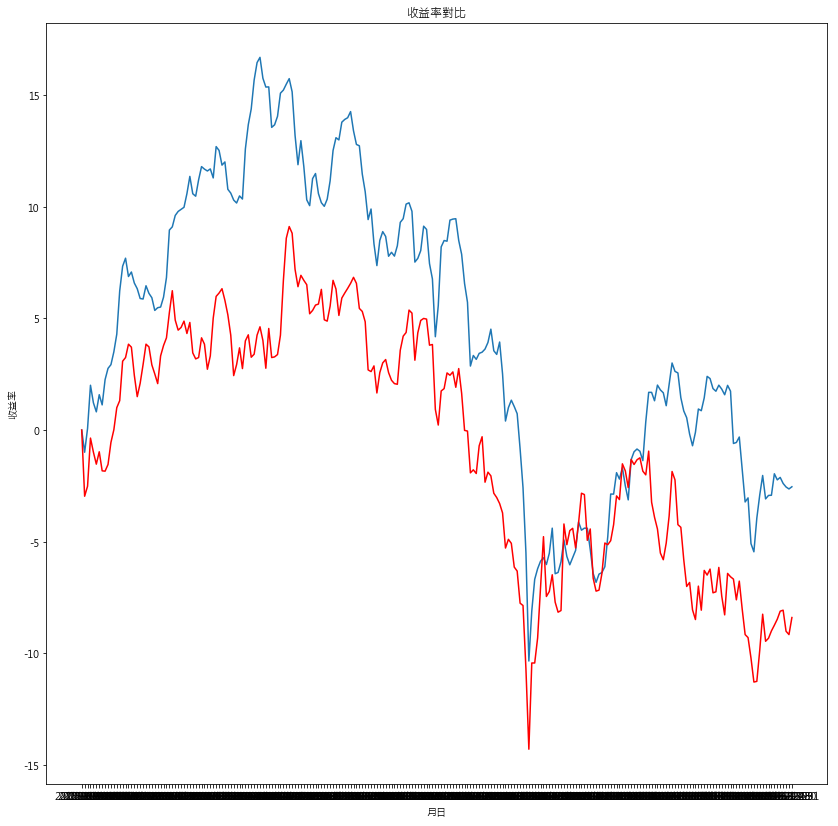

In [9]:
profitVisualize = KUpDownRate()
profitVisualize.getProfitPicture()

請輸入欲回測年：2012


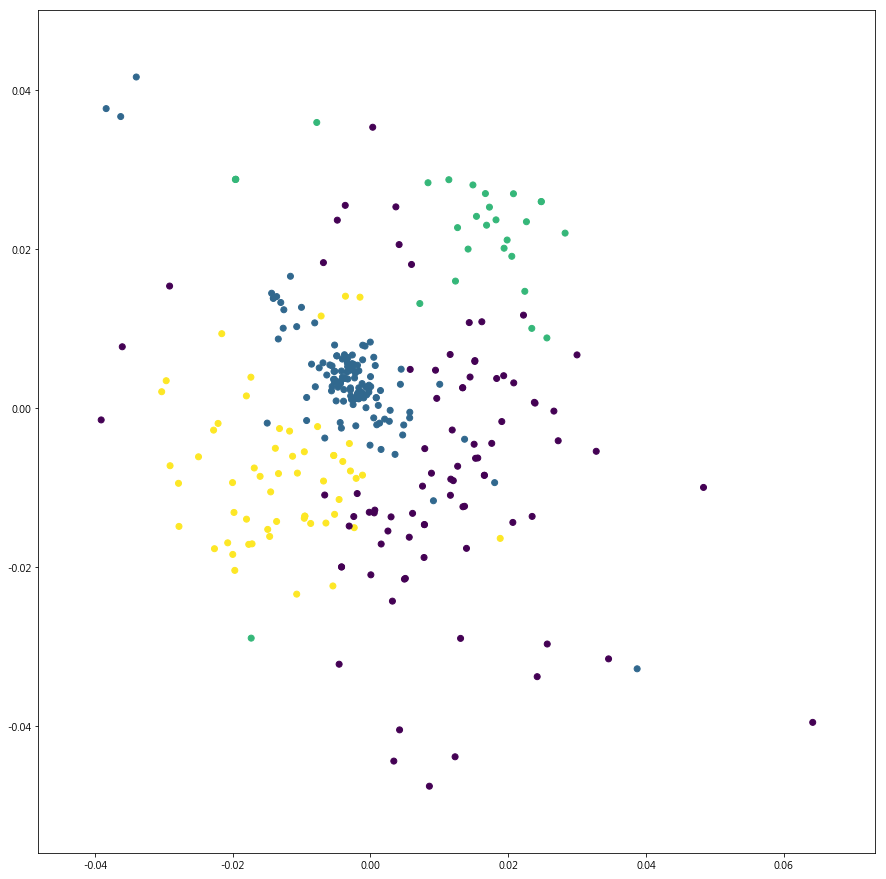

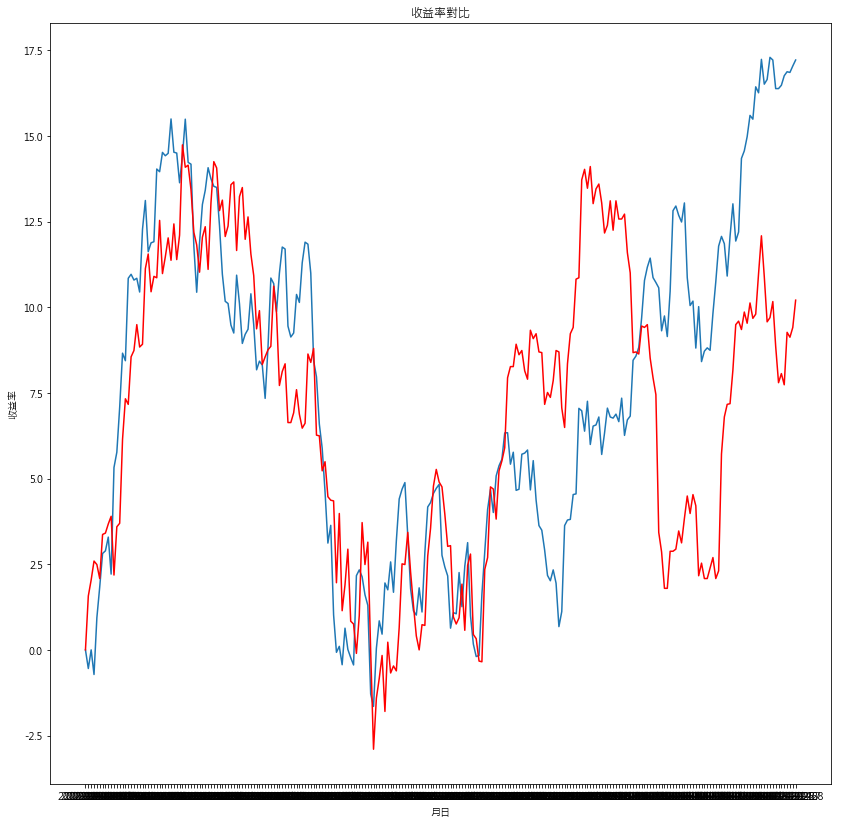

In [10]:
profitVisualize = HUpDownRate()
profitVisualize.getProfitPicture()